In [26]:
# Imports
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
from scipy.stats import t
import community 
from networkx.algorithms.community import greedy_modularity_communities
import community.community_louvain as community_louvain

# Explore the behaviours of malicious users 
1. PCA: Malicious VS Non-Malicious

- PCA loadings help identify key behaviors and personality traits that define variance in user activity data.
- Behaviors include file copying and domain interactions; personality traits are derived from the OCEAN model.
- Comparative analysis of PCA loadings between malicious and non-malicious users reveals distinct patterns:
  - Certain features are more prominent among malicious users, differentiating their behavior from non-malicious users.


In [11]:
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')
g_highimportancepcafeatures_path = os.path.join(processed_dir, 'G_highimportancePCAfeatures.pickle')
user_interaction_graph_path = os.path.join(processed_dir, 'user_interaction_graph.pickle')


# Read the multi-part Parquet dataset
data = pd.read_parquet(final_dataset_path).reset_index(drop = True)
data.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,False
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,False
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,False
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,False
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,False
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,False
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,False
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,False


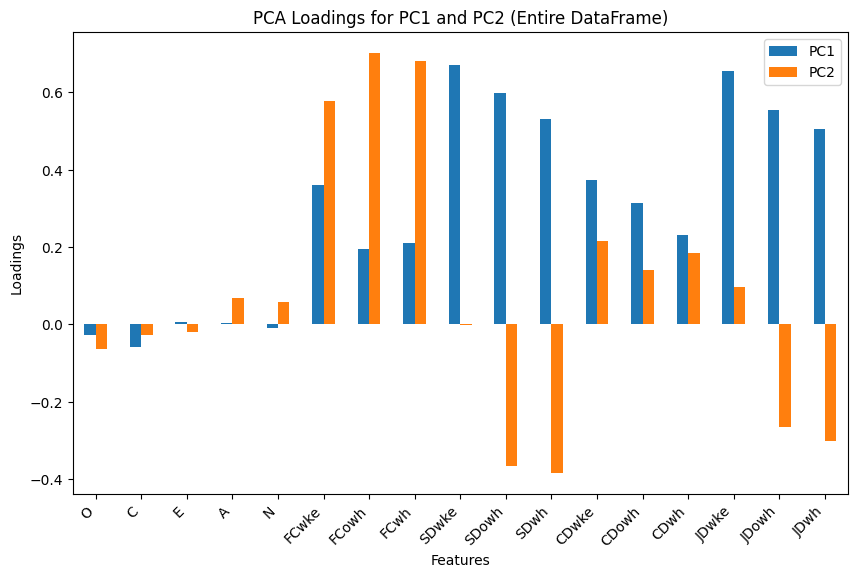

PCA Loadings for PC1 and PC2 (Entire DataFrame):
            PC1       PC2
O     -0.027438 -0.063714
C     -0.058659 -0.027575
E      0.006821 -0.018724
A      0.004482  0.069755
N     -0.008042  0.058521
FCwke  0.360245  0.578797
FCowh  0.196360  0.701848
FCwh   0.209770  0.682578
SDwke  0.672074 -0.000204
SDowh  0.597861 -0.366508
SDwh   0.532451 -0.384308
CDwke  0.372612  0.215637
CDowh  0.314416  0.140781
CDwh   0.232068  0.184068
JDwke  0.655284  0.095992
JDowh  0.553772 -0.265114
JDwh   0.505562 -0.300899


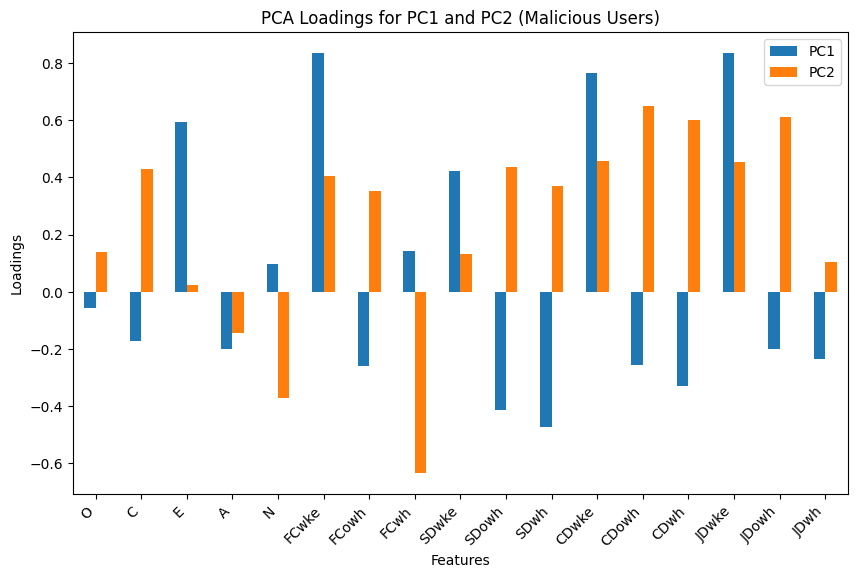

PCA Loadings for PC1 and PC2 (Malicious Users):
            PC1       PC2
O     -0.055193  0.138337
C     -0.172176  0.430476
E      0.592929  0.022325
A     -0.200634 -0.144464
N      0.098203 -0.370682
FCwke  0.834811  0.405964
FCowh -0.257898  0.351602
FCwh   0.144348 -0.633621
SDwke  0.421730  0.133880
SDowh -0.413102  0.438007
SDwh  -0.471289  0.368672
CDwke  0.763659  0.457594
CDowh -0.255594  0.649535
CDwh  -0.330020  0.602178
JDwke  0.834346  0.455694
JDowh -0.201083  0.610376
JDwh  -0.235523  0.105157


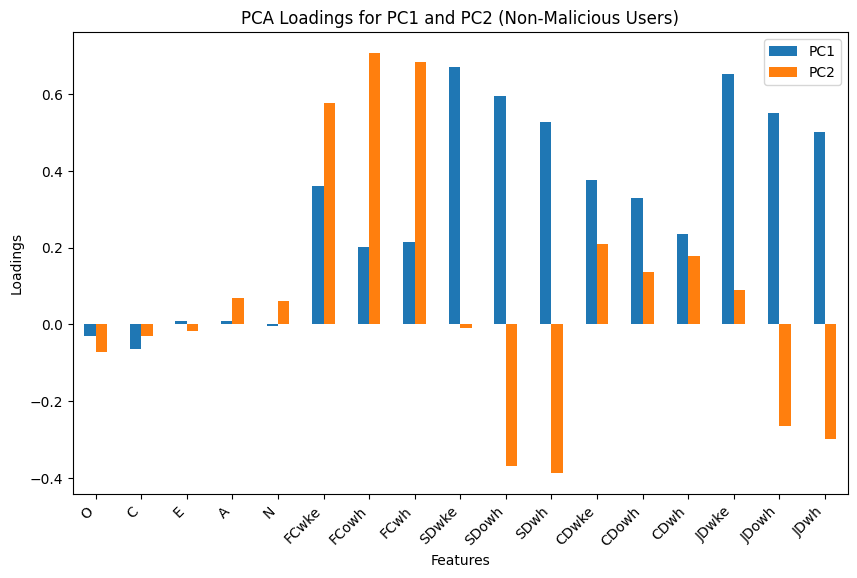

PCA Loadings for PC1 and PC2 (Non-Malicious Users):
            PC1       PC2
O     -0.029445 -0.070902
C     -0.064188 -0.030363
E      0.008781 -0.017228
A      0.007937  0.067690
N     -0.003798  0.061966
FCwke  0.361692  0.576643
FCowh  0.201905  0.707474
FCwh   0.214545  0.685535
SDwke  0.670831 -0.008116
SDowh  0.595759 -0.369703
SDwh   0.528727 -0.387623
CDwke  0.375698  0.209557
CDowh  0.329856  0.136683
CDwh   0.236599  0.178769
JDwke  0.654171  0.088809
JDowh  0.551634 -0.263972
JDwh   0.503005 -0.299445


In [7]:
pca_df = data.copy()
features = ['O', 'C', 'E', 'A', 'N', 'FCwke', 'FCowh', 'FCwh', 'SDwke', 'SDowh', 'SDwh', 'CDwke', 'CDowh', 'CDwh', 'JDwke', 'JDowh', 'JDwh']

X = pca_df[features]
X_std = (X - X.mean()) / X.std()

pca_all = PCA()
pca_all.fit(X_std)
loadings_all_pc1_pc2 = pca_all.components_[:2].T * np.sqrt(pca_all.explained_variance_[:2])

loadings_all_df = pd.DataFrame(loadings_all_pc1_pc2, columns=['PC1', 'PC2'], index=features)

plt.figure(figsize=(10, 6))
loadings_all_df.plot(kind='bar', ax=plt.gca())
plt.title('PCA Loadings for PC1 and PC2 (Entire DataFrame)')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.xticks(rotation=45, ha='right')
plt.show()

print("PCA Loadings for PC1 and PC2 (Entire DataFrame):")
print(loadings_all_df)

malicious_df = pca_df[pca_df['malicious'] == 1]

X_malicious = malicious_df[features]
X_std_malicious = (X_malicious - X_malicious.mean()) / X_malicious.std()

pca_malicious = PCA()
pca_malicious.fit(X_std_malicious)
loadings_malicious_pc1_pc2 = pca_malicious.components_[:2].T * np.sqrt(pca_malicious.explained_variance_[:2])

loadings_malicious_df = pd.DataFrame(loadings_malicious_pc1_pc2, columns=['PC1', 'PC2'], index=features)

plt.figure(figsize=(10, 6))
loadings_malicious_df.plot(kind='bar', ax=plt.gca())
plt.title('PCA Loadings for PC1 and PC2 (Malicious Users)')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.xticks(rotation=45, ha='right')
plt.show()

print("PCA Loadings for PC1 and PC2 (Malicious Users):")
print(loadings_malicious_df)

non_malicious_df = pca_df[pca_df['malicious'] == 0]

X_nonmalicious = non_malicious_df[features]
X_std_nonmalicious = (X_nonmalicious - X_nonmalicious.mean()) / X_nonmalicious.std()

pca_nonmalicious = PCA()
pca_nonmalicious.fit(X_std_nonmalicious)
loadings_nonmalicious_pc1_pc2 = pca_nonmalicious.components_[:2].T * np.sqrt(pca_nonmalicious.explained_variance_[:2])

loadings_nonmalicious_df = pd.DataFrame(loadings_nonmalicious_pc1_pc2, columns=['PC1', 'PC2'], index=features)

plt.figure(figsize=(10, 6))
loadings_nonmalicious_df.plot(kind='bar', ax=plt.gca())
plt.title('PCA Loadings for PC1 and PC2 (Non-Malicious Users)')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.xticks(rotation=45, ha='right')
plt.show()

print("PCA Loadings for PC1 and PC2 (Non-Malicious Users):")
print(loadings_nonmalicious_df)


## PCA Loadings Analysis

### Entire DataFrame:
- **PC1**: Positive loadings for behaviors outside of standard work hours, especially `FCwke`, `SDwke`, `JDwke`.
- **PC2**: `FCowh`, `FCwh`, and `FCwke` have significant positive loadings; `SDowh` and `SDwh` show negative correlations.

### Malicious Users:
- **PC1**: High positive loadings for weekend activities (`FCwke`, `CDwke`, `JDwke`) and negative for some domain interactions (`SDowh`, `SDwh`).
- **PC2**: `C`, `CDowh`, `CDwh`, `JDowh`, and `FCowh` stand out with positive loadings; `N`, `FCwh`, and `A` are inversely related.

### Non-Malicious Users:
- **PC1 & PC2**: Loading patterns are similar to the entire dataset, suggesting consistent behaviors across all users.

### Comparative Insights:
- **Behavioral Patterns**: Malicious users' loadings highlight weekend and after-hours activities as significant behavior indicators.
- **OCEAN Traits**: Differences in `C` and `N` loadings between malicious and non-malicious users suggest a correlation with malicious behaviors.
- **Principal Component Focus**: For malicious users, PC1 emphasizes weekend activities, while PC2 captures a contrast between conscientiousness and domain activity against neuroticism and work hour activities.

These PCA loadings suggest that certain time-related behaviors and personality traits could be predictive of malicious activities.


In [15]:
df = data.copy()

Code below takes 1h to run, use G_highimportancePCAfeatures.pickle

In [ ]:
# Selecting the high importance features from PCA
high_importance_features = ['FCwke', 'CDwke', 'JDwke', 'SDowh', 'SDwh', 'C', 'CDowh', 'CDwh', 'JDowh', 'FCowh', 'N', 'FCwh', 'A']

# Create a new DataFrame with only the high importance features
high_importance_df = df[high_importance_features]

# Create a network graph
G_highimportancePCAfeatures = nx.Graph()

# Add nodes with color attribute based on maliciousness
node_color_map = {0: 'blue', 1: 'red'}
for i, row in df.iterrows():
    G_highimportancePCAfeatures.add_node(row['user'], color=node_color_map[row['malicious']])

# Adding edges between users based on similarity in high importance features
for i, row in high_importance_df.iterrows():
    print(i)
    for j in range(i+1, len(high_importance_df)):
        row2 = high_importance_df.iloc[j]
        similarity = sum(abs(row - row2))  # Manhattan distance
        if similarity < 20:  # Adjust threshold as needed
            G_highimportancePCAfeatures.add_edge(df.iloc[i]['user'], df.iloc[j]['user'], weight=similarity)

pickle.dump(G_highimportancePCAfeatures, open('G_highimportancePCAfeatures.pickle', 'wb'))

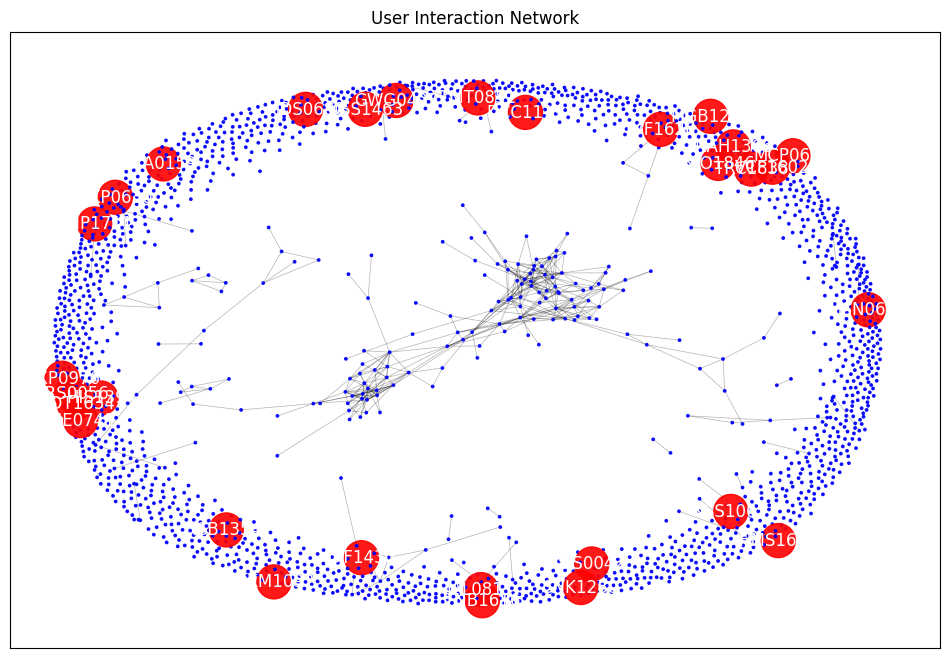

In [16]:
G_highimportancePCAfeatures = pickle.load(open(g_highimportancepcafeatures_path, 'rb'))
malicious_node_size = 600  # Larger size for visibility
default_node_size = 3
node_colors = [G_highimportancePCAfeatures.nodes[n]['color'] for n in G_highimportancePCAfeatures.nodes()]
node_sizes = [malicious_node_size if data['color'] == 'red' else default_node_size for _, data in G_highimportancePCAfeatures.nodes(data=True)]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_highimportancePCAfeatures, k=0.3, iterations=50)
nx.draw_networkx_nodes(G_highimportancePCAfeatures, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G_highimportancePCAfeatures, pos, alpha=0.3, width=0.5)
malicious_labels = {n: n if d['color'] == 'red' else '' for n, d in G_highimportancePCAfeatures.nodes(data=True)}
nx.draw_networkx_labels(G_highimportancePCAfeatures, pos, labels=malicious_labels, font_size=12, font_color='white')

plt.title('User Interaction Network')
plt.show()

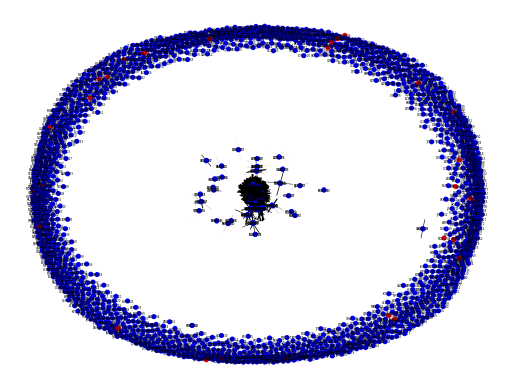

In [17]:
pos = nx.spring_layout(G_highimportancePCAfeatures)  # positions for all nodes
colors = [node[1]['color'] for node in G_highimportancePCAfeatures.nodes(data=True)]

# nodes
nx.draw_networkx_nodes(G_highimportancePCAfeatures, pos, node_color=colors, node_size=7)

# edges
weights = [G_highimportancePCAfeatures[u][v]['weight'] for u, v in G_highimportancePCAfeatures.edges()]
nx.draw_networkx_edges(G_highimportancePCAfeatures, pos, width=weights)

# labels
nx.draw_networkx_labels(G_highimportancePCAfeatures, pos, font_size=2, font_family='sans-serif')

plt.axis('off')  
plt.show()  

too complex

## Network Graph Analysis: Personality Traits

### Community Detection
- Visualizes densely interconnected clusters, indicating user groups with similar traits.
- Reveals organizational structures and potential teams based on shared behaviors.

### Malicious Behavior Correlation
- Utilizes color coding (red for malicious, blue for non-malicious) to show the distribution of users.
- Helps identify patterns or concentrations of malicious users, informing security measures.


In [19]:
total_users = len(df)

malicious_users = df[df['malicious'] == 1]
num_malicious_users = len(malicious_users)

malicious_percentage = (num_malicious_users / total_users) * 100

print("Total number of users:", total_users)
print("Number of malicious users:", num_malicious_users)
print("Percentage of malicious users: {:.2f}%".format(malicious_percentage))

# Visualization
traits = ['O', 'C', 'E', 'A', 'N']
trait_labels = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
trait_values = [malicious_users[trait].mean() for trait in traits]

Total number of users: 2000
Number of malicious users: 30
Percentage of malicious users: 1.50%


Code below builds second graph and takes a few minutes to run. Use pickled file

In [ ]:
G = nx.Graph()

# Adding nodes with color attribute based on maliciousness
node_color_map = {'malicious': 'red', 'non-malicious': 'blue'}
for i, row in df.iterrows():
    print(i+1,row[0])
    G.add_node(row['user'], color=node_color_map['malicious' if row['malicious'] == 1 else 'non-malicious'])

# Adding edges between users based on similarity in personality traits
for i, row in df.iterrows():
    print(i+1,row[0])
    for j in range(i+1, len(df)):
        row2 = df.iloc[j]
        similarity = sum(abs(row[traits] - row2[traits]))  # Manhattan distance
        if similarity < 20:  # Adjust threshold as needed
            G.add_edge(row['user'], row2['user'], weight=similarity)
            
pickle.dump(G, open('user_interaction_graph.pickle', 'wb'))

In [21]:
G = pickle.load(open(user_interaction_graph_path, 'rb'))

In [27]:
seed = 42

# Identifying communities
communities = greedy_modularity_communities(G)
# Sort communities by size (largest first) and select the top 3
sorted_communities = sorted(communities, key=len, reverse=True)[:3]

# Assign community colors and labels only to the top 3 communities
community_colors = plt.cm.rainbow(np.linspace(0, 1, len(sorted_communities)))
node_to_community_color = {}
node_community_labels = {}
for i, nodes in enumerate(sorted_communities):
    for node in nodes:
        node_to_community_color[node] = community_colors[i]
        node_community_labels[node] = f"Community {i}"

# Create a color map for all nodes, default color gray for nodes not in top 3 communities
default_color = 'gray'
node_colors = [node_to_community_color.get(node, default_color) for node in G.nodes()]

# Create node sizes map
malicious_node_size = 200  # Larger size for visibility
default_node_size = 3
node_sizes = [malicious_node_size if G.nodes[n]['color'] == 'red' else default_node_size for n in G.nodes()]

# Create the cluster averages DataFrame for top 3 communities
cluster_averages = pd.DataFrame(columns=['Cluster', 'Avg_O', 'Avg_C', 'Avg_E', 'Avg_A', 'Avg_N'])
for cluster_number, nodes in enumerate(sorted_communities):
    cluster_users = df[df['user'].isin(nodes)]
    malicious_users = cluster_users[cluster_users['malicious'] == 1]
    
    if len(malicious_users) > 3:  # Proceed only if more than 3 malicious users
        avg_values = {
            'Avg_O': cluster_users['O'].mean(),
            'Avg_C': cluster_users['C'].mean(),
            'Avg_E': cluster_users['E'].mean(),
            'Avg_A': cluster_users['A'].mean(),
            'Avg_N': cluster_users['N'].mean(),
            'Num_Malicious_Users': len(malicious_users)
        }
        cluster_avg_df = pd.DataFrame([avg_values], index=[cluster_number])
        cluster_avg_df.insert(0, 'Cluster', f"Community {cluster_number}")
        cluster_averages = pd.concat([cluster_averages, cluster_avg_df])

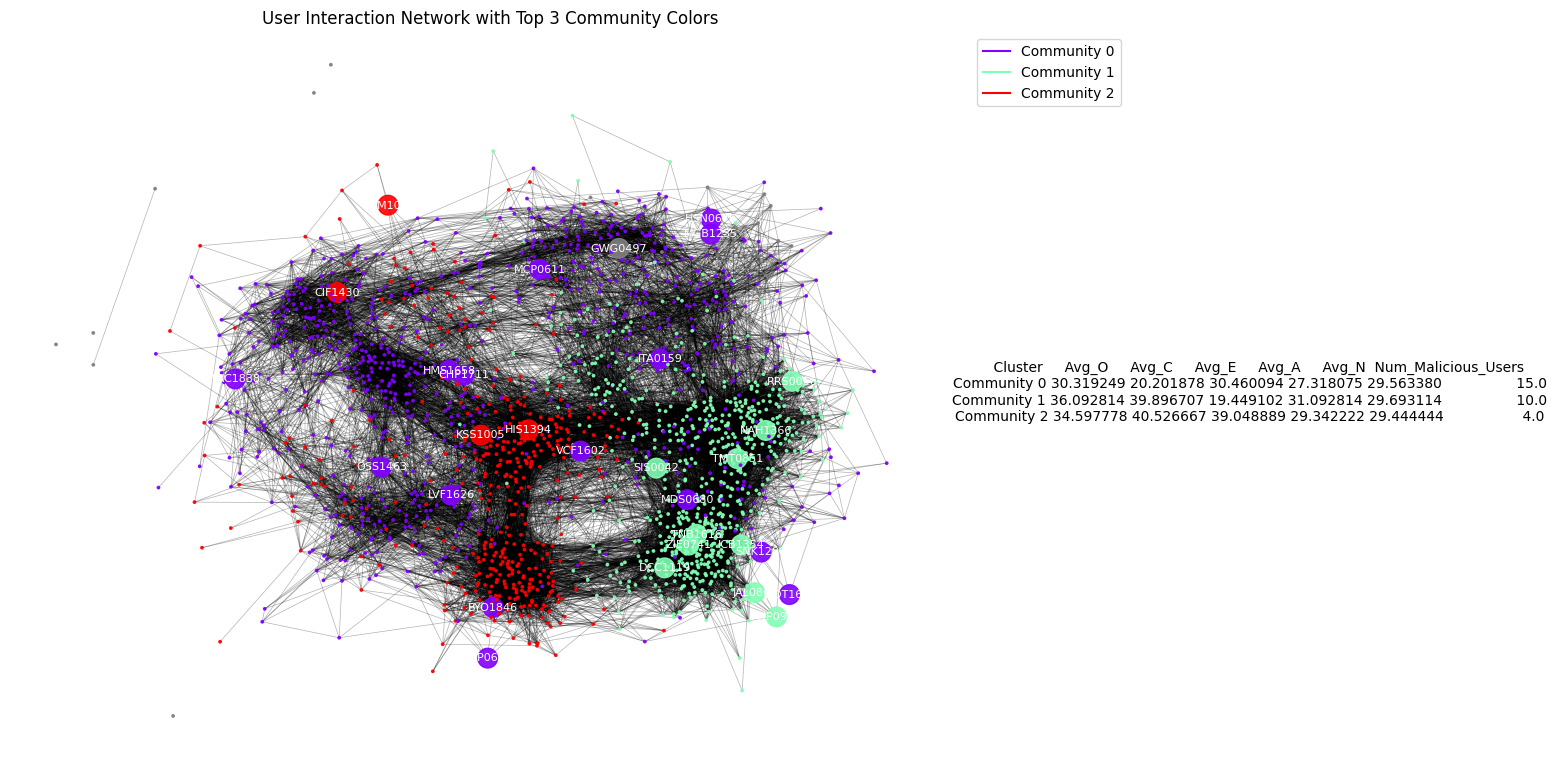

In [28]:
# Visualization
fig = plt.figure(figsize=(16, 8))
network_ax = fig.add_axes([0.05, 0.05, 0.6, 0.9])
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=seed)

nx.draw_networkx_nodes(G, pos, ax=network_ax, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, ax=network_ax, alpha=0.3, width=0.5)
malicious_labels = {node: node if G.nodes[node]['color'] == 'red' else '' for node in G.nodes()}
nx.draw_networkx_labels(G, pos, ax=network_ax, labels=malicious_labels, font_size=8, font_color='white')
network_ax.set_title('User Interaction Network with Top 3 Community Colors')
network_ax.axis('off')

text_ax = fig.add_axes([0.7, 0.05, 0.25, 0.9])
text_ax.axis('off')
cluster_averages_str = cluster_averages.to_string(index=False)
text_ax.text(0.5, 0.5, cluster_averages_str, transform=text_ax.transAxes, fontsize=10, verticalalignment='center', horizontalalignment='center')

for i, color in enumerate(community_colors):
    network_ax.plot([], [], color=color, label=f"Community {i}")
network_ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

# Community Sorting and Filtering: Before assigning colors or labels, the communities are sorted by size, and only the top 3 are selected for further processing.
# Color and Label Assignment: Nodes in the top 3 communities are given a unique color and label. Nodes not in these communities are colored gray by default.
# Node Sizes and Colors: Nodes are sized based on their 'malicious' attribute, and colored according to their community or the default gray.
# Cluster Averages: Calculations are only done for the top 3 communities.
# Visualization: The network plot shows nodes with their respective community colors (or gray), and the textual side panel lists the averages for these communities only.

Archive


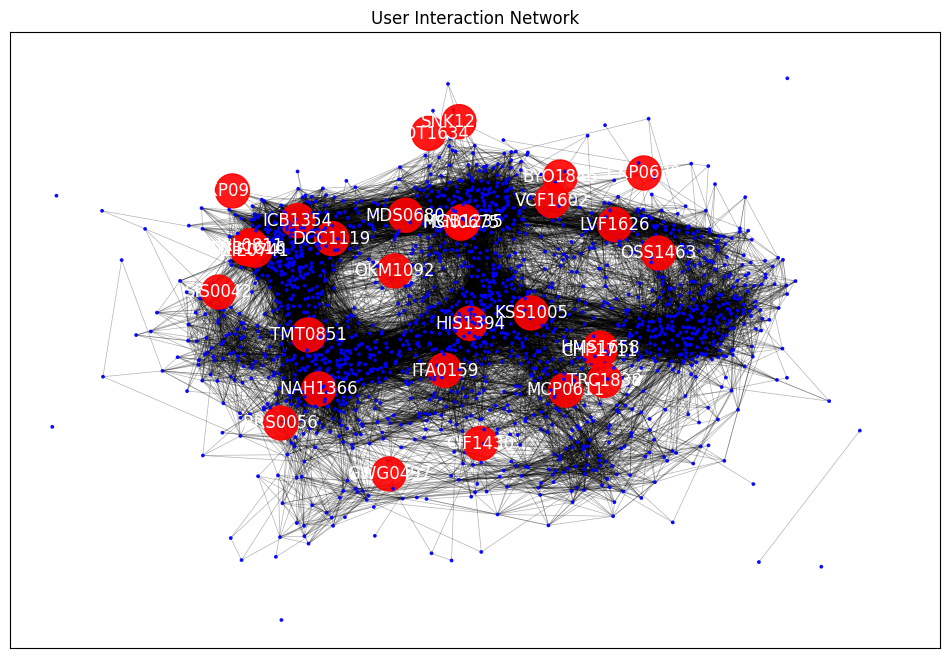

In [ ]:
malicious_node_size = 600  # Larger size for visibility
default_node_size = 3
node_colors = [G.nodes[n]['color'] for n in G.nodes()]
node_sizes = [malicious_node_size if data['color'] == 'red' else default_node_size for _, data in G.nodes(data=True)]

plt.figure(figsize=(12, 8))

# Generate a spring layout with increased space between nodes
pos = nx.spring_layout(G, k=0.3, iterations=50)  # Adjust k and iterations for better spacing

# Draw nodes with higher opacity for visibility
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)

# Draw edges with reduced width and transparency
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

# Draw labels for malicious nodes with a larger font size and white font color for visibility
malicious_labels = {n: n if d['color'] == 'red' else '' for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=malicious_labels, font_size=12, font_color='white')

# Add a title and show the plot without axis for a cleaner look
plt.title('User Interaction Network')
# plt.axis('off')  # Hide the axis for a neater presentation
plt.show()